In [145]:
import pickle
import warnings
import gzip
import ujson

import numpy as np
import networkx as nx
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict, defaultdict
from itertools import combinations, product
from scipy import stats
from scipy.spatial import distance

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [4]:
preds = []

for path in tqdm(glob('../data/embeds-en/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            title = ' '.join(line.pop('tokens'))
            line.pop('embedding')
            preds.append(OrderedDict(title=title, **line))

100%|██████████| 65/65 [00:23<00:00,  2.81it/s]


In [5]:
df = pd.DataFrame(preds)

In [6]:
domains = list(set([r['label'] for r in preds]))

In [7]:
domains

['dailykos.com',
 'foxnews.com',
 'bloomberg.com',
 'thehill.com',
 'washingtonpost.com',
 'huffingtonpost.com',
 'breitbart.com',
 'nytimes.com',
 'dailycaller.com',
 'buzzfeed.com',
 'cnn.com',
 'apnews.com',
 'wsj.com']

In [32]:
rows = []

for d1 in tqdm(domains):

    weights = np.array([
        [r[f'p_{d}'] for d in domains]
        for r in preds
        if r['label'] == d1
    ])
    
    weights = weights.sum(0) / len(weights)
    
    for d2, w in zip(domains, weights):
        rows.append((d1, d2, w))

100%|██████████| 13/13 [00:07<00:00,  1.62it/s]


In [33]:
wdf = pd.DataFrame(rows, columns=('d1', 'd2', 'w'))

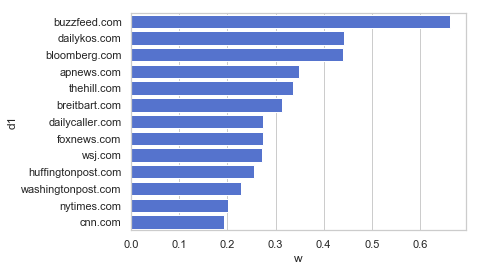

In [34]:
w_true = wdf[wdf.d1==wdf.d2].sort_values('w', ascending=False)
sns.barplot(x='w', y='d1', data=w_true, color='RoyalBlue')

In [35]:
def plot_weights(d):
    pdf = wdf[wdf.d1==d].sort_values('w', ascending=False)
    sns.barplot(x='w', y='d2', data=pdf, color='RoyalBlue')
    plt.show()

buzzfeed.com


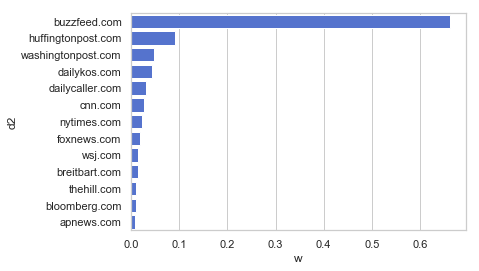

dailykos.com


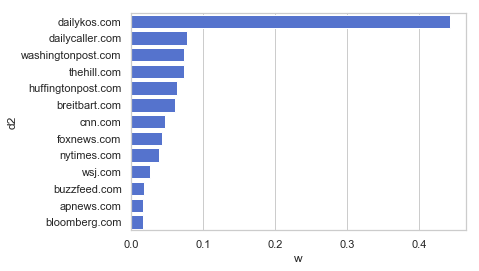

bloomberg.com


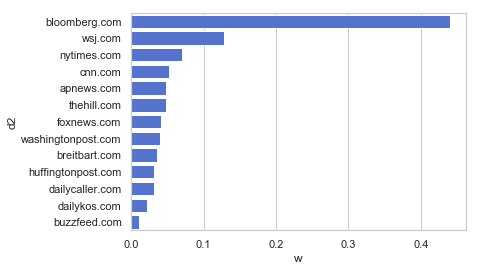

apnews.com


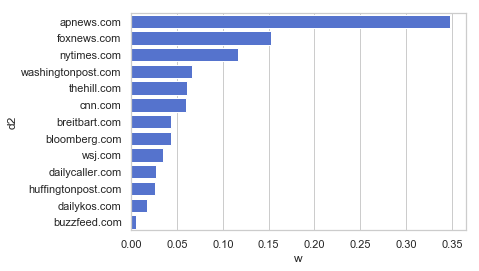

thehill.com


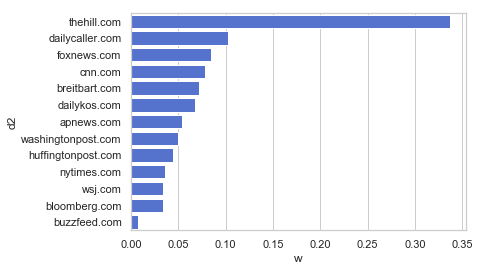

breitbart.com


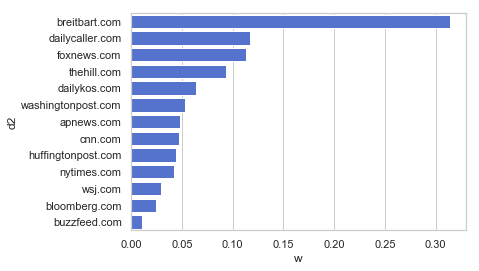

dailycaller.com


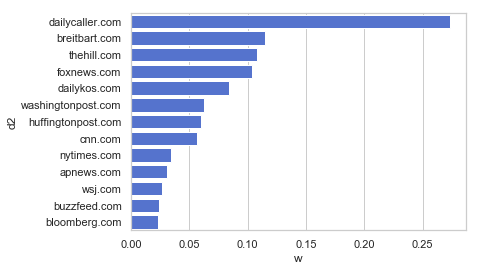

foxnews.com


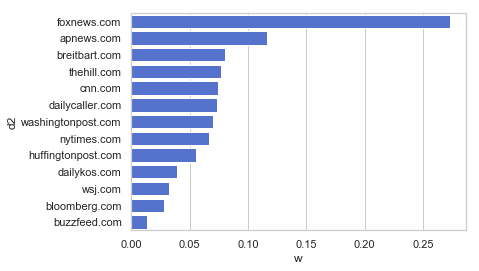

wsj.com


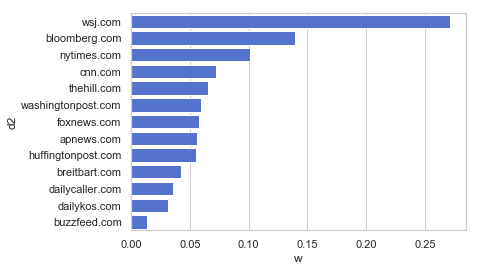

huffingtonpost.com


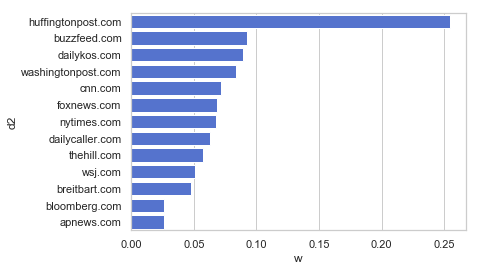

washingtonpost.com


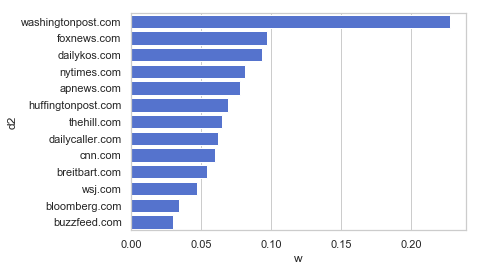

nytimes.com


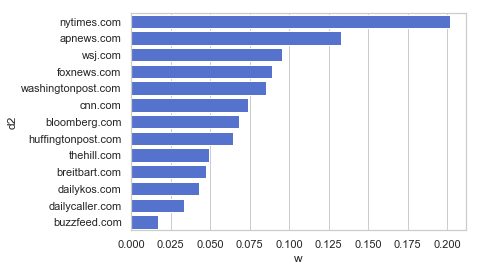

cnn.com


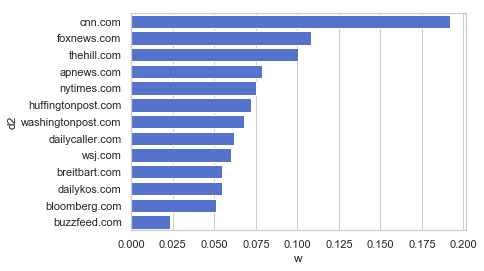

In [36]:
for d in w_true.d1:
    print(d)
    plot_weights(d)

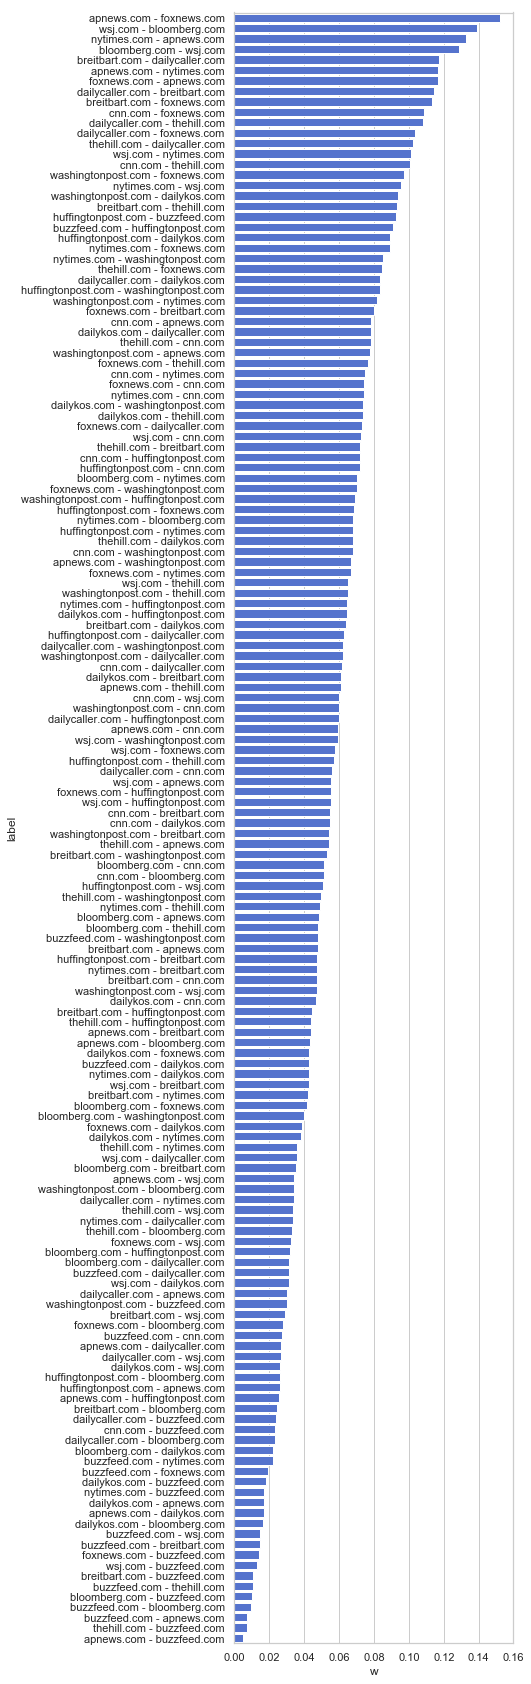

In [42]:
pdf = wdf[wdf.d1!=wdf.d2].sort_values('w', ascending=False)
pdf['label'] = pdf[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

plt.figure(figsize=(5,30))
sns.barplot(x='w', y='label', data=pdf, color='RoyalBlue')

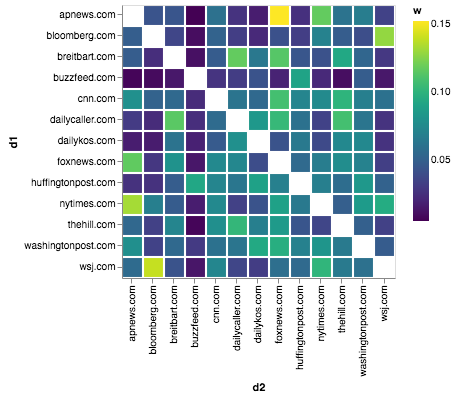

In [98]:
alt.Chart(wdf[wdf.d1!=wdf.d2]).mark_rect().encode(x='d2:O', y='d1:O', color='w:Q', tooltip='d2')

In [67]:
actors = defaultdict(set)

for path in tqdm(glob('../data/link-actor-graph.json/*.gz')):
    with gzip.open(path, 'rb') as fh:
        for line in fh:
            r = ujson.loads(line)
            actors[r['domain']].add(r['actor_id'])

100%|██████████| 10/10 [00:42<00:00,  4.09s/it]


In [68]:
def jaccard_sim(s1, s2):
    return len(set.intersection(s1, s2)) / len(set.union(s1, s2))

In [71]:
rows = []
for d1, d2 in tqdm(product(domains, domains)):
    d = jaccard_sim(actors[d1], actors[d2])
    rows.append((d1, d2, d))

169it [01:24,  2.58it/s]


In [82]:
jdf = pd.DataFrame(rows, columns=('d1', 'd2', 's'))

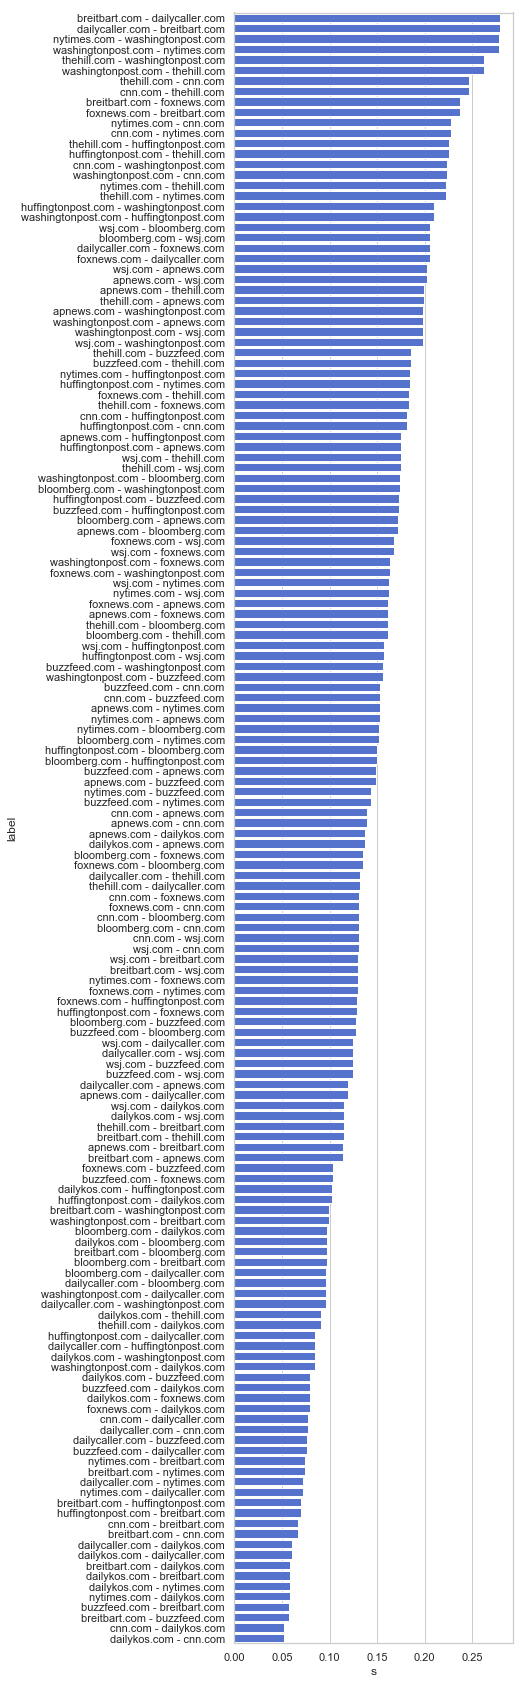

In [84]:
pdf = jdf[jdf.d1!=jdf.d2].sort_values('s', ascending=False)
pdf['label'] = pdf[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

plt.figure(figsize=(5,30))
sns.barplot(x='s', y='label', data=pdf, color='RoyalBlue')

In [125]:
def clf_dist(d1):
    
    weights = np.array([
        [r[f'p_{d}'] for d in domains]
        for r in preds
        if r['label'] == d1
    ])
    
    return weights.sum(0) / len(weights)

In [140]:
clf_dists = np.stack([clf_dist(d) for d in tqdm(domains)])

100%|██████████| 13/13 [00:08<00:00,  1.48it/s]


In [131]:
def actor_dist(d1):

    js = np.array([
        jaccard_sim(actors[d1], actors[d2])
        for d2 in domains
    ])

    return js / js.sum()

In [141]:
actor_dists = np.stack([actor_dist(d) for d in tqdm(domains)])

100%|██████████| 13/13 [01:26<00:00,  6.51s/it]


In [150]:
for d, cd, ad in zip(domains, clf_dists, actor_dists):
    print(d, stats.spearmanr(cd.argsort(), ad.argsort()))

dailykos.com SpearmanrResult(correlation=0.07692307692307691, pvalue=0.8027630076692551)
foxnews.com SpearmanrResult(correlation=-0.03296703296703297, pvalue=0.9148564744875125)
bloomberg.com SpearmanrResult(correlation=0.3186813186813187, pvalue=0.2885831614447202)
thehill.com SpearmanrResult(correlation=-0.21978021978021978, pvalue=0.47061485147214255)
washingtonpost.com SpearmanrResult(correlation=-0.33516483516483514, pvalue=0.2629431403593601)
huffingtonpost.com SpearmanrResult(correlation=-0.09890109890109891, pvalue=0.7478683035983906)
breitbart.com SpearmanrResult(correlation=0.26373626373626374, pvalue=0.3839365166506743)
nytimes.com SpearmanrResult(correlation=0.0934065934065934, pvalue=0.7615000227827016)
dailycaller.com SpearmanrResult(correlation=0.26373626373626374, pvalue=0.3839365166506743)
buzzfeed.com SpearmanrResult(correlation=0.6648351648351648, pvalue=0.013165575845550252)
cnn.com SpearmanrResult(correlation=-0.32967032967032966, pvalue=0.27133505450523554)
apnews

In [172]:
g = nx.Graph()
for d, cd in zip(domains, clf_dists):
    for i in cd.argsort()[-4:-1]:
        g.add_edge(d, domains[i], weight=(cd[i]**2)*10)

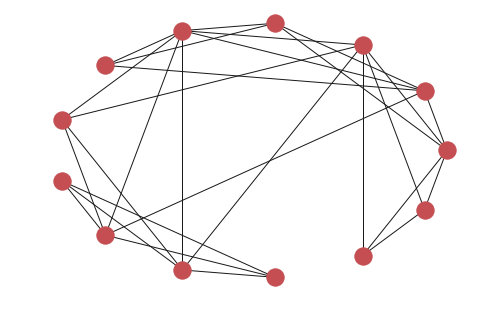

In [174]:
nx.draw_circular(g)